In [21]:
import torch
import random
import numpy as np
import gymnasium as gym
from collections import deque
import matplotlib.pyplot as plt
import gymnasium as gym


In [22]:

# Hyperparameters
LEARNING_RATE = 0.001 # Standard for adam optimizer
EPISODES = 500 # Arbitary, set higher to see patterns
BATCH_SIZE = 64 # Standard batch size, for xp replay
GAMMA = 0.99 # 

# epsilon greedy strat
EPSILON_START = 1.0
EPSILON_END = 0.01
EPSILON_DECAY = 0.995

TARGET_FREQ = 10 # update target network every 10 eps
REPLAY_BUFFER_SIZE = 10000 # memory capacity for xp replay

In [23]:

# Environment setup
env = gym.make('CartPole-v1')
state_dim = env.observation_space.shape[0] # input (4 states)
action_dim = env.action_space.n # output (2 actions (left, right))

In [24]:

# DQN Model
class DQN(torch.nn.Module):
    # two hidden layers, 128 neurons, input neurons = state_dim, output neurons = action_dim
    def __init__(self, state_dim, action_dim):
        super(DQN, self).__init__()
        self.network = torch.nn.Sequential(
            torch.nn.Linear(state_dim, 128),
            torch.nn.ReLU(),
            torch.nn.Linear(128, 128),
            torch.nn.ReLU(),
            torch.nn.Linear(128, action_dim)
        )
        
    # forward pass
    def forward(self, x):
        return self.network(x)


In [25]:

# Replay Buffer
class ReplayBuffer:
    def __init__(self, capacity):
        # fill from reverse
        self.buffer = deque(maxlen=capacity)
    
    def push(self, state, action, reward, next_state, done):
        self.buffer.append((state, action, reward, next_state, done))

    def sample(self, batch_size):
        batch = random.sample(self.buffer, batch_size)
        states, actions, rewards, next_states, dones = zip(*batch)
        return (
            torch.FloatTensor(states),
            torch.LongTensor(actions),
            torch.FloatTensor(rewards),
            torch.FloatTensor(next_states),
            torch.FloatTensor(dones)
        ) # to ensure matching tensor dim

    def __len__(self):
        return len(self.buffer)

# Training function
def train_dqn(policy_net, target_net, optimizer, replay_buffer, batch_size):
    if len(replay_buffer) < batch_size:
        return None

    states, actions, rewards, next_states, dones = replay_buffer.sample(batch_size)

    # Compute Q-values
    q_values = policy_net(states).gather(1, actions.unsqueeze(1)).squeeze()

    # Compute target Q-values
    with torch.no_grad(): #
        next_q_values = target_net(next_states).max(1)[0]
        target_q_values = rewards + GAMMA * next_q_values * (1 - dones)

    # Compute loss
    loss = torch.nn.MSELoss()(q_values, target_q_values)

    # Optimize
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    return loss.item()


In [26]:

# Training loop
def train_agent(use_replay_buffer=True, train_every_2_episodes=False):
    # init main and target network
    policy_net = DQN(state_dim, action_dim)
    target_net = DQN(state_dim, action_dim)
    
    target_net.load_state_dict(policy_net.state_dict()) # same weights and biases from main to target
    target_net.eval()# disables dropout, ensures consistent Q-values
    
    
    optimizer = torch.optim.Adam(policy_net.parameters(), LEARNING_RATE) # use Adam optimzer with 0.001 lr
    replay_buffer = ReplayBuffer(REPLAY_BUFFER_SIZE) if use_replay_buffer else None # init memory

    epsilon = EPSILON_START
    rewards_history = []
    losses = []

    for episode in range(EPISODES):
        state, _ = env.reset()
        total_reward = 0
        done = False

        while not done:
            # Epsilon-greedy action selection
            if random.random() < epsilon:
                action = env.action_space.sample()
            else:
                with torch.no_grad():
                    q_values = policy_net(torch.FloatTensor(state))
                    action = q_values.argmax().item()

            next_state, reward, terminated, truncated, _ = env.step(action)
            done = terminated or truncated
            total_reward += reward

            if use_replay_buffer:
                replay_buffer.push(state, action, reward, next_state, done)

            state = next_state

        # Decay epsilon
        epsilon = max(EPSILON_END, epsilon * EPSILON_DECAY)

        # Train with replay buffer
        if use_replay_buffer:
            if not train_every_2_episodes or (episode % 2 == 1):
                loss = train_dqn(policy_net, target_net, optimizer, replay_buffer, BATCH_SIZE)
                if loss is not None:
                    losses.append(loss)

        # Update target network
        if episode % TARGET_FREQ == 0:
            target_net.load_state_dict(policy_net.state_dict())

        rewards_history.append(total_reward)

    return rewards_history, losses


In [27]:
# Training function
def train_dqn(policy_net, target_net, optimizer, replay_buffer, batch_size):
    if len(replay_buffer) < batch_size:
        return None

    states, actions, rewards, next_states, dones = replay_buffer.sample(batch_size)

    # Compute Q-values
    q_values = policy_net(states).gather(1, actions.unsqueeze(1)).squeeze()

    # Compute target Q-values
    with torch.no_grad():
        next_q_values = target_net(next_states).max(1)[0]
        target_q_values = rewards + GAMMA * next_q_values * (1 - dones)

    # Compute loss
    loss = torch.nn.MSELoss()(q_values, target_q_values)

    # Optimize
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    return loss.item()


In [28]:

# Main training loop
def train_agent(use_replay_buffer=True, train_every_2_episodes=False):
    policy_net = DQN(state_dim, action_dim)
    target_net = DQN(state_dim, action_dim)
    target_net.load_state_dict(policy_net.state_dict())
    target_net.eval()

    optimizer = torch.optim.Adam(policy_net.parameters(), lr=LEARNING_RATE)
    replay_buffer = ReplayBuffer(REPLAY_BUFFER_SIZE) if use_replay_buffer else None

    epsilon = EPSILON_START
    rewards_history = []
    losses = []

    for episode in range(EPISODES):
        state, _ = env.reset()
        total_reward = 0
        done = False

        while not done:
            # Epsilon-greedy action selection
            if random.random() < epsilon:
                action = env.action_space.sample()
            else:
                with torch.no_grad():
                    q_values = policy_net(torch.FloatTensor(state))
                    action = q_values.argmax().item()

            next_state, reward, terminated, truncated, _ = env.step(action)
            done = terminated or truncated
            total_reward += reward

            if use_replay_buffer:
                replay_buffer.push(state, action, reward, next_state, done)

            state = next_state

        # Decay epsilon
        epsilon = max(EPSILON_END, epsilon * EPSILON_DECAY)

        # Train with replay buffer
        if use_replay_buffer:
            if not train_every_2_episodes or (episode % 2 == 1):
                loss = train_dqn(policy_net, target_net, optimizer, replay_buffer, BATCH_SIZE)
                if loss is not None:
                    losses.append(loss)

        # Update target network
        if episode % TARGET_FREQ == 0:
            target_net.load_state_dict(policy_net.state_dict())

        rewards_history.append(total_reward)

    return rewards_history, losses


In [29]:

# Run experiments
rewards_no_replay, _ = train_agent(use_replay_buffer=False)
rewards_with_replay, losses_with_replay = train_agent(use_replay_buffer=True)
rewards_with_replay_every_2, losses_with_replay_every_2 = train_agent(use_replay_buffer=True, train_every_2_episodes=True)


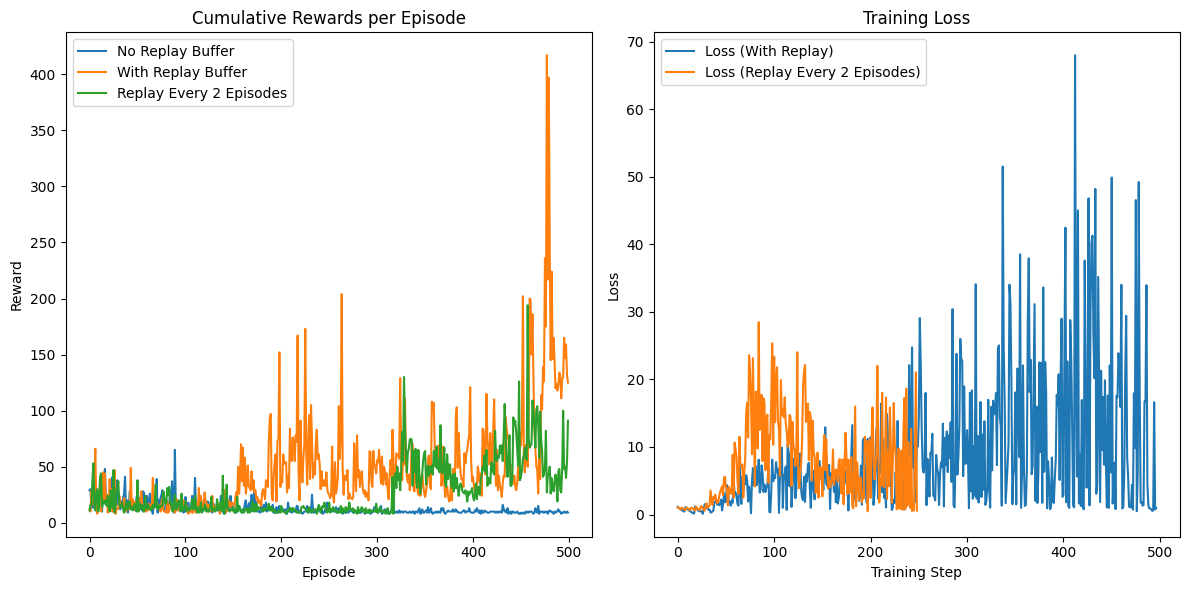

In [30]:

# Plot results
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.plot(rewards_no_replay, label="No Replay Buffer")
plt.plot(rewards_with_replay, label="With Replay Buffer")
plt.plot(rewards_with_replay_every_2, label="Replay Every 2 Episodes")
plt.title("Cumulative Rewards per Episode")
plt.xlabel("Episode")
plt.ylabel("Reward")
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(losses_with_replay, label="Loss (With Replay)")
plt.plot(losses_with_replay_every_2, label="Loss (Replay Every 2 Episodes)")
plt.title("Training Loss")
plt.xlabel("Training Step")
plt.ylabel("Loss")
plt.legend()

plt.tight_layout()
plt.show()